Лабораторная работа № 7. Автоассоциативные сети с узким горлом

Выполнил: Степанов Данила Михайлович

Группа: М8О-407Б-20

Вариант: 22

Цель работы:

Целью работы является исследование свойств автоассоциативных сетей с узким горлом,
алгоритмов обучения, а также применение сетей для выполнения линейного и нелинейного
анализа главных компонент набора данных.

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

Напишем функции для генерации точек линии, заданной согласно варианту

In [ ]:
def generate_points(count, a, b, alpha):
  T = [random.uniform(0, 2 * np.pi) for i in range(count)]
  points = [(a * np.cos(t + alpha), b * np.sin(t + alpha)) for t in T]
  points = [(x * np.cos(alpha) - y * np.sin(alpha), x * np.sin(alpha) + y * np.cos(alpha)) for x, y in points]
  return points

In [ ]:
points = generate_points(100, 0.3, 0.7, np.pi / 4)

In [ ]:
x = [point[0] for point in points]
y = [point[1] for point in points]

Отобразим точки обучающего множества

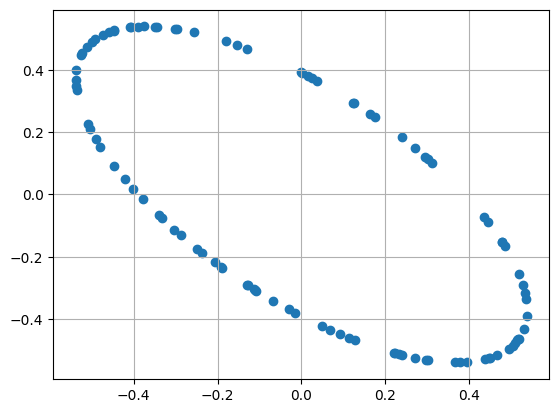

In [ ]:
plt.scatter(x, y)
plt.grid(True)

Часть 1. Сеть с узким горлом для отображения наборах данных с выделением первой главной компоненты данных

In [ ]:
X = torch.tensor(points, dtype=torch.float)

Опишем архитектуру автоассоциативной сети для первой части задания

In [ ]:
class ANN(nn.Module):
  def __init__(self, in_features, hidden_size):
    super().__init__()
    self.lin1 = nn.Linear(in_features, hidden_size)
    self.lin2 = nn.Linear(hidden_size, in_features)

  def forward(self, x):
    x = self.lin1(x)
    x = self.lin2(x)
    return x

Опишем функцию для обучения сети



In [ ]:
def train(model, X, criterion, optimizer, epochs=100):
  if epochs == 10000: step = 1000
  else: step = 100
  model.train()
  history = []
  for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X)
    loss = 0.0
    for train_sample, output_sample in zip(X, outputs):
      loss += criterion(output_sample, train_sample)

    loss /= X.shape[0]
    history.append(loss.item())
    if epoch % step == 0:
      print(f"loss: {loss.item()}")
    loss.backward()
    optimizer.step()
  return history


Определим модель, функцию потерь и оптимизатор для обучения сети

In [ ]:
epochs = 1000

model = ANN(2, 1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

history = train(model, X, criterion, optimizer, epochs=epochs)

loss: 0.2290172129869461
loss: 0.17753510177135468
loss: 0.1531992107629776
loss: 0.13543185591697693
loss: 0.11659280955791473
loss: 0.09261476248502731
loss: 0.06639514118432999
loss: 0.04522440955042839
loss: 0.03290463611483574
loss: 0.027255145832896233


Построим кривую обучения

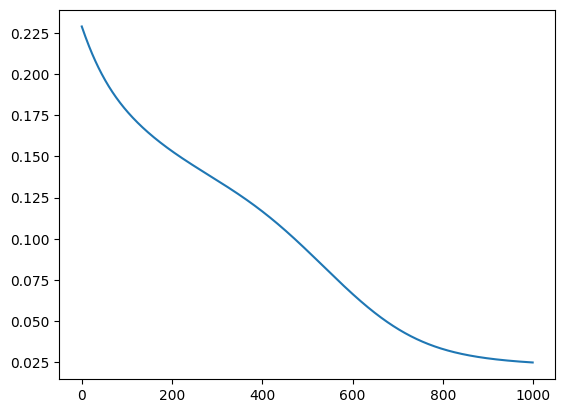

In [ ]:
plt.plot(range(epochs), history)

Напишем функцию, отображающую входы и выходы модели

In [ ]:
def show_result(model, X, x, y):
  model.eval()
  outputs = model(X).clone().detach().cpu().numpy()
  x_points = [point[0] for point in outputs]
  y_points = [point[1] for point in outputs]
  plt.scatter(x, y, c='r')
  plt.scatter(x_points, y_points, c='b')
  plt.legend(["Обучающая выборка", "Выходы модели"])

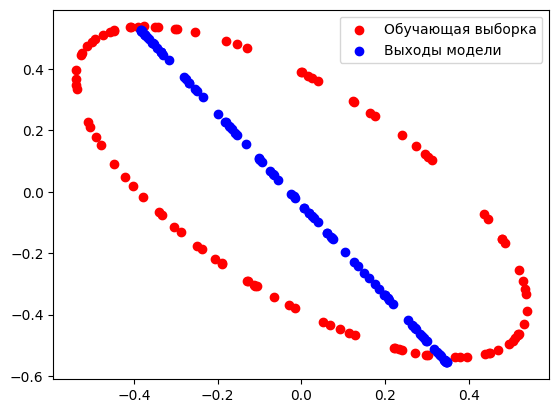

In [ ]:
show_result(model, X, x, y)

Часть 2. Сеть с узким горлом для аппроксимации кривой на плоскости с выделением первой нелинейной главной компоненты

Опишем функцию для генерации точек кривой

In [ ]:
def generate_curve_points(start, end, h, third_dim=False):
  if not third_dim:
    points = [((2 ** phi) * np.cos(phi), (2 ** phi) * np.sin(phi)) for phi in np.arange(start, end, h)]
  else:
    points = [((2 ** phi) * np.cos(phi), (2 ** phi) * np.sin(phi), phi) for phi in np.arange(start, end, h)]
  return points

In [ ]:
points = generate_curve_points(0, 2 * np.pi, 0.025)
x = [point[0] for point in points]
y = [point[1] for point in points]

Отобразим построенную кривую

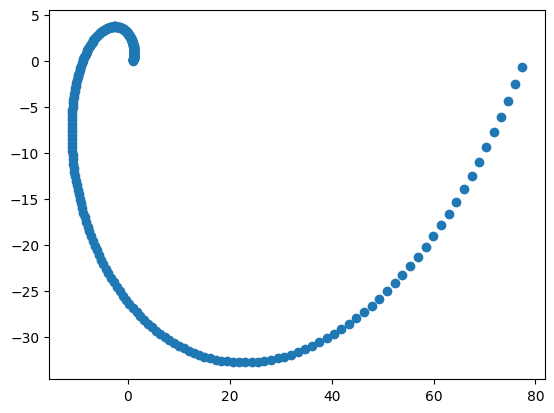

In [ ]:
plt.scatter(x, y)

Опишем архитектуру автоассоциативной сети для второй части задания

In [ ]:
class ANN(nn.Module):
  def __init__(self, in_features, hidden_size1, hidden_size2, hidden_size3):
    super().__init__()
    self.lin1 = nn.Linear(in_features, hidden_size1)
    self.activation = nn.Tanh()
    self.lin2 = nn.Linear(hidden_size1, hidden_size2)
    self.lin3 = nn.Linear(hidden_size2, hidden_size3)
    self.lin4 = nn.Linear(hidden_size3, hidden_size2)
    self.lin5 = nn.Linear(hidden_size2, hidden_size1)
    self.lin6 = nn.Linear(hidden_size1, in_features)

  def forward(self, x):
    x = self.lin1(x)
    x = self.lin2(x)
    x = self.activation(self.lin3(x))
    x = self.activation(self.lin4(x))
    x = self.activation(self.lin5(x))
    x = self.lin6(x)
    return x

In [ ]:
X = torch.tensor(points, dtype=torch.float)

Определим модель, функцию потерь и оптимизатор для обучения модели

In [ ]:
epochs = 10000

model = ANN(2, 10, 1, 10)
optimizer = torch.optim.Adam(model.parameters())

history = train(model, X, criterion, optimizer, epochs=epochs)

loss: 346.50482177734375
loss: 334.7931823730469
loss: 316.9102783203125
loss: 297.4140319824219
loss: 278.7080383300781
loss: 261.8153076171875
loss: 246.75210571289062
loss: 233.17636108398438
loss: 220.75291442871094
loss: 209.0933074951172
loss: 197.90911865234375
loss: 187.70431518554688
loss: 178.55215454101562
loss: 170.2851104736328
loss: 162.74806213378906
loss: 155.82395935058594
loss: 149.4242706298828
loss: 143.4805908203125
loss: 137.93833923339844
loss: 132.7524871826172
loss: 127.88512420654297
loss: 123.3036117553711
loss: 118.97957611083984
loss: 114.8880615234375
loss: 111.00730895996094
loss: 107.31798553466797
loss: 103.8033218383789
loss: 100.44869232177734
loss: 97.24199676513672
loss: 94.17323303222656
loss: 91.23368835449219
loss: 88.4163589477539
loss: 85.7166976928711
loss: 83.1291275024414
loss: 80.64896392822266
loss: 78.2718734741211
loss: 75.99385833740234
loss: 73.81053924560547
loss: 71.71595001220703
loss: 69.70621490478516
loss: 67.77538299560547
loss:

Отобразим кривую обучения

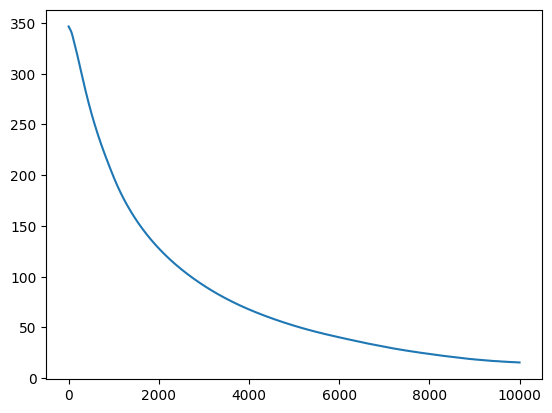

In [ ]:
plt.plot(range(epochs), history)

Отобразим полученный результат

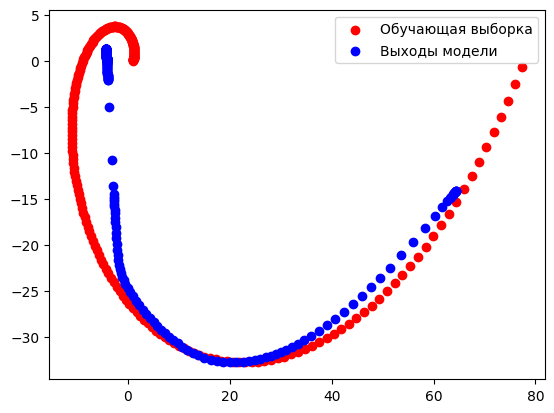

In [ ]:
show_result(model, X, x, y)

Часть 3. Аппроксимация пространственной
кривой с выделением старших нелинейных главных компонент данных.

Сгенерируем обучающие примеры и отобразим кривую в пространствте

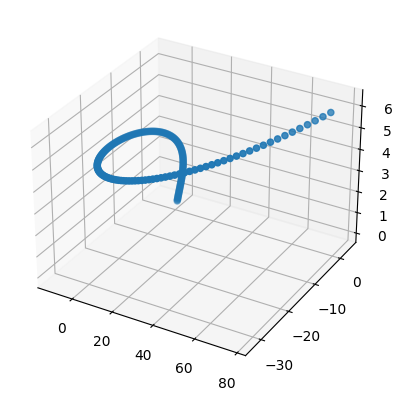

In [ ]:
points = generate_curve_points(0, 2 * np.pi, 0.025, third_dim=True)

x = [point[0] for point in points]
y = [point[1] for point in points]
z = [point[2] for point in points]

ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z)

In [ ]:
X = torch.tensor(points, dtype=torch.float)

Определим модель, функцию потерь, оптимизатор для обучения сети

In [ ]:
epochs = 10000

model = ANN(3, 10, 2, 10)
optimizer = torch.optim.Adam(model.parameters())

history = train(model, X, criterion, optimizer, epochs=epochs)

loss: 234.8662872314453
loss: 225.9237518310547
loss: 211.1040802001953
loss: 193.42074584960938
loss: 178.77590942382812
loss: 166.68495178222656
loss: 156.43492126464844
loss: 147.51547241210938
loss: 139.5542755126953
loss: 132.3533477783203
loss: 125.77447509765625
loss: 119.71662902832031
loss: 114.09310913085938
loss: 108.81719970703125
loss: 103.82139587402344
loss: 99.05990600585938
loss: 94.5089111328125
loss: 90.16976165771484
loss: 86.02111053466797
loss: 82.03501892089844
loss: 78.1963119506836
loss: 74.50074768066406
loss: 70.9466552734375
loss: 67.53145599365234
loss: 64.24701690673828
loss: 61.08739471435547
loss: 58.046836853027344
loss: 55.12189865112305
loss: 52.3099479675293
loss: 49.6042366027832
loss: 46.966529846191406
loss: 44.442344665527344
loss: 42.04506301879883
loss: 39.75652313232422
loss: 37.57281494140625
loss: 35.49070358276367
loss: 33.50706100463867
loss: 31.618391036987305
loss: 29.82097816467285
loss: 28.111827850341797
loss: 26.487747192382812
loss:

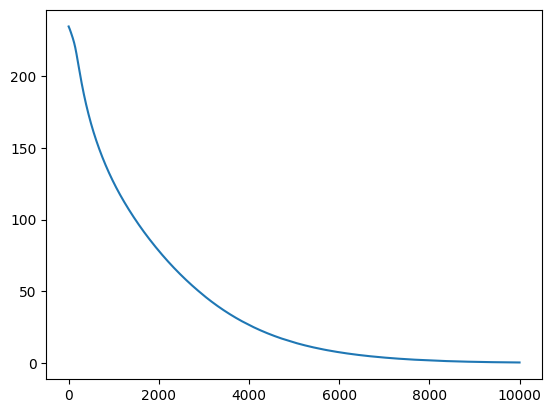

In [ ]:
plt.plot(range(epochs), history)

In [ ]:
def show_result3D(model, X, x, y, z):

  model.eval()
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.set_xlabel('x axis')
  ax.set_ylabel('y axis')
  ax.set_zlabel('z axis')

  ax.scatter(x, y, z, c='r')
  outputs = model(X).clone().detach().cpu().numpy()
  x_points = [point[0] for point in outputs]
  y_points = [point[1] for point in outputs]
  z_points = [point[2] for point in outputs]
  ax.scatter(x_points, y_points, z_points, c='b')
  ax.view_init(elev=45, azim=60)
  ax.legend(["Обучающая выборка", "Выходы модели"])

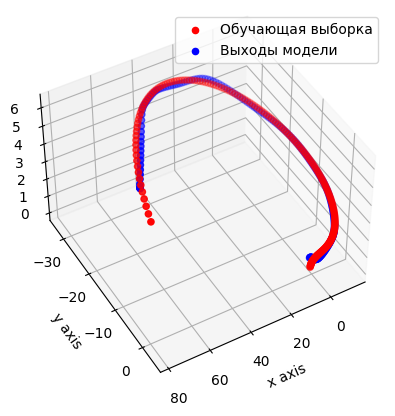

In [ ]:
show_result3D(model, X, x, y, z)

Вывод:

Автоассоциативные сети довольно интересная архитектура нейронных сетей,которая имеет множество применений: например, генерация данных или снижение размерности методом выделения главных компонент. Метод PCA сводится к поиску направлений,вдоль которых признак объектов имеет наибольшую дисперсию и задача сводится к поиску собственных значений матрицы. Решение на основе автоассоциативных сетей
оринтированно на поиск на наиболее важных признаков с точки зрения модели, однако по полученным результам можно заметить,что модель также выделяет направления с наибольшей дисперсией.